## 6.1 파이프라인을 사용한 효율적인 워크플로

In [37]:
# 위스콘신 유방암 데이터셋 로드

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
                 header=None)

In [38]:
# feature와 target 데이터로 분류 & LabelEncoder로 범주형 데이터를 수치형 데이터로 인코딩

from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [39]:
le.transform(['M', 'B'])

array([1, 0])

In [40]:
# 학습 데이터와 테스트 데이터로 split

from sklearn.model_selection import train_test_split

"""
- stratify 값으로는 target 값을 지정
- stratify값을 target 값으로 지정해주면 target의 class 비율을 유지 한 채로 데이터 셋을 split

- random_state 파라미터는 train_test_split 함수를 호출할 때마다 동일한 학습/테스트 데이터셋을 생성하기 위한 난수값
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

#### Explanation)

- 표준화, 주성분 분석, 로지스틱 회귀를 포함하는 pipeline 객체 생성

- make_pipeline 함수는 여러 개의 사이킷런 변환기(입력에 대해 fit 메서드와 transform 메서드를 지원하는 객체)와 그 뒤에 fit 메서드와predict 메서드를 구현한 사이킷런 사이킷런 추정기를 연결할 수 있다.

- Pipeline 객체의 fit 메서드를 호출하면 데이터가 중간 단계에 있는 모든 변환기의 fit 메서드와 transform 메서드를 차례로 거쳐 추정기 객체(파이프라인의 마지막 단계)에 도달한다.
- 추정기는 변환된 훈련 데이터셋을 사용하여 학습
- 파이프라인의 중간 단계의 횟수는 제한이 없다.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), 
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [42]:
# 추정기 객체를 주피터 노트북에서 시각화

from sklearn import set_config

set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가

### 6.2.1 홀드아웃 방법

- 홀드아웃 방법: 초기 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누는 것
- 모델 선택 (model selection): 최적의 파라미터 혹은 하이퍼파라미터를 선택하는 것

홀드아웃 교차 검증
- 초기 데이터를 훈련 데이터, 검증 데이터, 테스트 데이터의 세 개 부분으로 나눈다.
- 검증 데이터셋을 사용하여 반복적으로 다른 하이퍼파라미터 값에서 모델을 훈련한 후 성능을 평가하는 방식으로 최적의 하이퍼파라미터 값을 찾는다.

### 6.2.2 k-겹 교차 검증

- 중복을 허용하지 않고 훈련 데이터셋을 k개의 fold로 랜덤하게 나눈다.
- (k - 1)개의 fold로 모델을 훈련하고 나머지 하나의 fold로 성능을 평가한다.
- 이런 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다. 
- 그다음 서로 다른 독립적인 fold에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산한다.
- 만족스러운 하이퍼파라미터 값을 찾은 후에는 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련한다.
- 그다음 독립적인 테스트 데이터셋을 사용하여 최종 성능 추정을 한다.

- k-겹 교차 검증은 중복을 허용하지 않는 리샘플링 기법 - 샘플이 독립적이고 공분산이 0이다.
- k-겹 교차 검증 방식은 홀드아웃 방식에 비해 훈련 데이터셋의 분할에 덜 민감한 성능 추정값을 얻을 수 있으며, 분산이 낮다.

#### Note) LOOVC 방법 (Leave-One-Out Cross-Validation)

- 폴드 개수가 훈련 샘플 개수와 같다. (k = n)
- 즉, 하나의 훈련 샘플이 각 반복에서 테스트 데이터로 사용된다. 

- 아주 작은 데이터셋을 사용할 때 권장되는 방법

In [43]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train) # 계층적 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 데이터셋에 있는 클래스 비율과 동일하도록 유지
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1, np.bincount(y_train[train]), score))

# bincount() : 0부터 가장 큰 값까지 각각의 발생 빈도수를 계산

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [44]:
print('CV 정확도: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV 정확도: 0.950 +/- 0.014


In [45]:
# k-겹 교차 검증
"""
cross_val_score 함수가 검증에 사용하는 기본 측정 지표는 회귀일 때는 R2, 분류일 때는 정확도
"""

from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1) 

# cv : 교차 검증 폴드 수
# n_jobs : 사용할 cpu 코어 수를 지정

print('CV 정확도 점수: %s' % scores)

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [46]:
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.950 +/- 0.014


In [47]:
# cross_validate 함수는 scoring 하이퍼파라미터에 여러 측정 지표를 설정하여 교차 검증에 사용할 수 있다.

from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, X=X_train, y=y_train, scoring=['accuracy'], cv=10, n_jobs=1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [48]:
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도: 0.950 +/- 0.014


In [49]:
# cross_val_predict 함수는 훈련 데이터셋의 각 샘플이 테스트 fold가 되었을 때 만들어진 예측을 반환

from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
preds

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,

## 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석

- 편향이 높은 모델 : 훈련 정확도와 검증 정확도의 차이는 작지만, 정확도 자체가 낮다.
- 분산이 높은 모델 : 훈련 정확도와 검증 정확도의 차이가 크다. 정확도 자체는 높다.

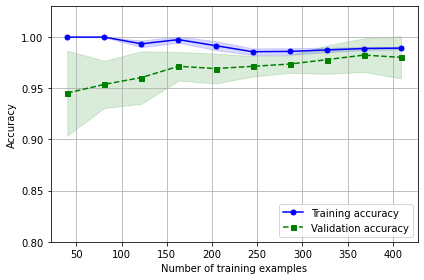

In [50]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

# trian_sizes : 학습 곡선을 생성하는 데 사용할 훈련 샘플의 개수나 비율을 지정할 수 있다. 
# linspace(start, stop, num) : start 와 stop 사이 범위에서 num 개수만큼 일정한 간격으로 요소 생성

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, 
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, 
         train_mean, 
         color='blue', 
         marker='o', 
         markersize=5, 
         label='Training accuracy')


# fill_between() : 그래프의 특정 영역을 색상으로 채우는 함수 -> 두 수평 방향의 곡선 사이를 채운다.
plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', 
         marker='s', markersize=5, label='Validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [51]:
(train_mean + train_std) - (train_mean - train_std)

array([0.        , 0.        , 0.00655738, 0.00601102, 0.00882353,
       0.00658143, 0.00625474, 0.00428135, 0.00292672, 0.00239559])

In [52]:
(test_mean + test_std) - (test_mean - test_std)

array([0.08294426, 0.04613706, 0.05134391, 0.02792254, 0.02908261,
       0.01997665, 0.01715486, 0.02780931, 0.03290192, 0.04126735])

### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사

/Users/ldw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ldw/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

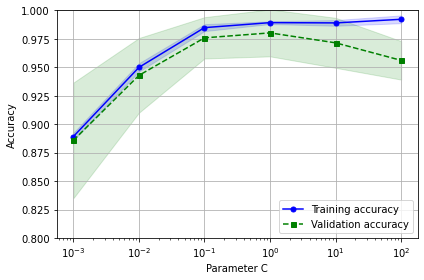

In [53]:
from sklearn.model_selection import validation_curve

# 로직스틱 회귀 분류기의 C(규제 파라미터)값에 대한 검증
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=X_train, 
                                             y=y_train,
                                             param_name='logisticregression__C', 
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log') # xscale, yscale -> 축의 스케일 설정
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## 6.4 Grid Search를 사용한 머신 러닝 모델 세부 튜닝

grid search: 하이퍼파라미터 최적화기법
- 하이퍼파라미터 값에 대한 최적의 조합을 찾음으로써 모델 성능을 향상시키는 기법

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
"""
gridsearhcv 클래스의 파라미터
- param_grid 매개변수에 튜닝하려는 매개변수를 딕셔너리의 리스트로 지정
- regit 매개변수를 true로 지정하면 전체 훈련 데이터셋에서 자동으로 gs.best_estimator_(최적의 파라미터 조합을 가진 모델)를 다시 훈련한다.
"""

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [55]:
# 최고의 성능을 가진 모델을 테스트 데이터셋을 사용하여 평가

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("테스트 정확도: %.3f" % clf.score(X_test, y_test))

테스트 정확도: 0.974


#### Note) Random 하이퍼파라미터 탐색

- 사이킷런에는 여러 가지 매개변수 조합을 샘플링하는 randomized search가 있다.
- RandomizedSearchCV 클래스를 사용하여 제한된 횟수 안에서 샘플링 분포로부터 랜덤한 매개변수 조합을 뽑는다.
- 랜덤 서치는 일반적으로 그리드 서치와 비슷한 성능을 내지만 훨씬 비용과 시간이 적게 든다.
- 매개변수 탐색 범위가 넓거나 규제 매개변수 C처럼 연속적인 값을 탐색해야 하는 경우에 랜덤서치가 더 효율적이다.
- RandomizedSearchCV 클래스는 n_iter 매개변수로 탐색 횟수를 조정할 수 있다.
- RandomizedSearchCV 클래스는 탐색할 매개변수 값을 리스트가 아닌 샘플링 가능한 분포의 형태로 전달해야한다.

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution = loguniform(0.0001, 1000.0) # 탐색할 하이퍼파라미터 값에 대한 분포
param_dist = [{'svc__C': distribution, 'svc__kernel': ['linear']},
              {'svc__C': distribution, 'svc__gamma': distribution, 'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc, 
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택

In [57]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [58]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid=[{'max_depth': [1,2,3,4,5,6,7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 +/- 0.016


## 6.5 여러 가지 성능 평가 지표

In [59]:
# 오차 행렬

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


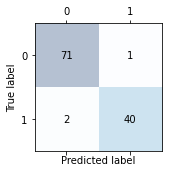

In [60]:
# 오차 행렬 시각화

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

### 6.5.2 분류 모델의 정밀도와 재현율 최적화

- 예측오차(ERR) = 잘못된 예측 합 / 전체 예측 샘플 개수
- 정확도(ACC) = 옳은 예측 합 / 전체 예측 샘플 개수

- 정밀도(precision) = TP / FP + TP -> positive라고 예측한 값 중 실제 positive인 비율
- 재현율(recall) = TP / FN + TP -> 실제 positive값 중 positive로 예측한 비율

- F1 score = 2 * (pre * rec) / (pre + rec)

In [61]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [62]:
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
             {'svc__C': c_gamma_range,
              'svc__gamma': c_gamma_range,
             'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### 6.5.3 ROC 곡선 그리기

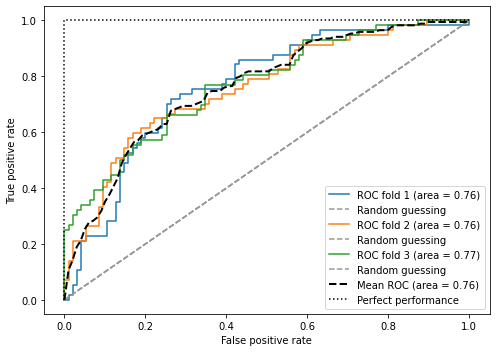

In [63]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2',
                                           random_state=1,
                                           C=100.0))

X_train2 = X_train[:, [4,14]]

cv = list(StratifiedKFold(n_splits=3, 
                          shuffle=True, 
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    plt.plot([0, 1], 
             [0, 1],
             linestyle='--',
             color=(0.6, 0.6, 0.6),
             label='Random guessing')
    
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 6.5.4 다중 분류의 성능 지표

In [64]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

## 6.6 불균형한 클래스 다루기

In [65]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [73]:
# 무조건 다수 클래스 (양성 종양의 클래스인 0)를 예측하는 모델은 거의 90%의 정확도를 달성, 왜냐하면 거의 90%의 데이터셋의 클래스가 0이기 때문에
# 이러한 경우, 정밀도보다는 재현율 지표를 사용하는 것이 적절

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [75]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], 
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링한 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링한 후 클래스 1의 샘플 개수: 357


In [76]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

In [77]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0